In [273]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import shutup

In [274]:
shutup.please()

In [74]:
dailydata = pd.read_csv('../data/co2-ppm-daily_csv.csv')
problemdata = pd.read_csv('../data/ppm.csv')

In [75]:
year_lengths = []
j = 1991
dates = [dailydata.iloc[i][0] for i in range(len(dailydata))]
yeardates = [i for i in dates if i.split('-')[0] == str(j)]
year_data = dailydata.loc[dailydata['date'].isin(yeardates)]
print(j, len(year_data))
year_lengths.append((j, len(year_data)))

print(max(year_lengths, key=lambda x: x[1]))

1991 359
(1991, 359)


In [200]:
num_years = len(problemdata)

In [216]:
YEAR = str(1991)

x_daily, y_daily = list(map(lambda x: x/359, range(359))), list(year_data.value)
x_yearly, y_yearly = list(problemdata.Year), list(problemdata.PPM)

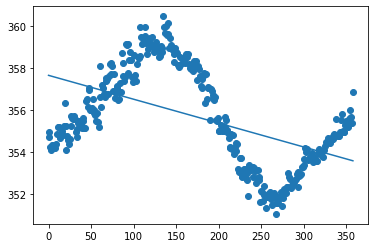

In [85]:
a, b = np.polyfit(x, y, 1)

plt.scatter(x, y)
plt.plot(x, a*x+b)

def cos_func(times, amp, freq, y=355.6131):
    inside = freq*times
    middle = amp*np.cos(inside)

    return middle + y

(x[list(y).index(min(y))] - x[list(y).index(max(y))])*2

popt, pcov = curve_fit(
    cos_func,
    x, y,
    p0=((max(y)-min(y))/2, 2*np.pi/300)
)

plt.plot(x, y, '.', label='Measured')
plt.plot(x, cos_func(pd.Series(x), popt[0], popt[1]), label='Best Fit')
plt.plot(x, cos_func(pd.Series(x), (max(y)-min(y))/2, 2*np.pi/300))

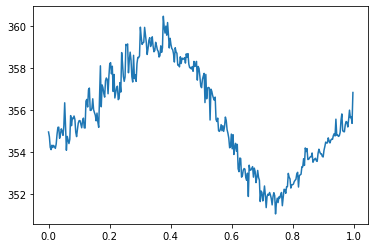

In [294]:
plt.plot(x_daily, y_daily)

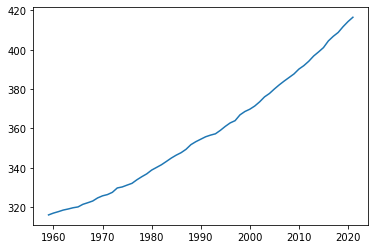

In [299]:
plt.plot(x_yearly, y_yearly)

In [293]:
x_daily

[0.0,
 0.002785515320334262,
 0.005571030640668524,
 0.008356545961002786,
 0.011142061281337047,
 0.013927576601671309,
 0.016713091922005572,
 0.019498607242339833,
 0.022284122562674095,
 0.025069637883008356,
 0.027855153203342618,
 0.03064066852367688,
 0.033426183844011144,
 0.036211699164345405,
 0.03899721448467967,
 0.04178272980501393,
 0.04456824512534819,
 0.04735376044568245,
 0.05013927576601671,
 0.052924791086350974,
 0.055710306406685235,
 0.0584958217270195,
 0.06128133704735376,
 0.06406685236768803,
 0.06685236768802229,
 0.06963788300835655,
 0.07242339832869081,
 0.07520891364902507,
 0.07799442896935933,
 0.0807799442896936,
 0.08356545961002786,
 0.08635097493036212,
 0.08913649025069638,
 0.09192200557103064,
 0.0947075208913649,
 0.09749303621169916,
 0.10027855153203342,
 0.10306406685236769,
 0.10584958217270195,
 0.10863509749303621,
 0.11142061281337047,
 0.11420612813370473,
 0.116991643454039,
 0.11977715877437325,
 0.12256267409470752,
 0.12534818941504

In [185]:
base_slope = float((problemdata.iloc[32][1] - problemdata.iloc[33][1])/(1991-1992))

In [261]:


def slope_with_respect_to_base(slope, base_slope):
    return np.math.tan(np.math.atan(slope) - np.math.atan(base_slope))

In [66]:
sum(year_data.iloc[i][1] for i in range(len(year_data))) / len(year_data)

355.61309192200554

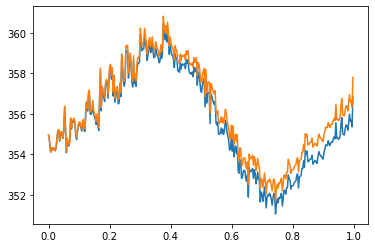

In [350]:
plt.plot(x_daily, y_daily)
# shifted_y_daily = []

plt.plot(x_daily, pd.Series(y_daily) + slope_with_respect_to_base(10, base_slope)*pd.Series(x_daily))
# plt.plot(x_yearly, y_yearly)

In [230]:
slope_with_respect_to_base(1, base_slope)

0.08695652173911154

In [340]:
interpol_data_y = pd.Series()

slopes = []

for ind, val in enumerate(x_yearly[:-1]):
    slope = y_yearly[ind+1] - y_yearly[ind]

    slope_w_respect = slope_with_respect_to_base(slope, base_slope)

    slopes.append(slope_w_respect)

    x_values = [i / 359 + val-1959 for i in range(359)]
    new_data = pd.Series(y_daily) + [i*slope_w_respect for i in x_values] - sum(y_daily)/len(y_daily)
    interpol_data_y = interpol_data_y.append(new_data)


In [341]:
slopes

[0.05052773411181958,
 -0.06818745350859855,
 -0.017852892168548646,
 -0.20638414969730626,
 -0.13732670677480663,
 -0.3104671791839205,
 0.23143774796898986,
 -0.017852892168548646,
 0.017333025190647167,
 0.3148180093151403,
 0.11637748624627915,
 -0.1300728407908717,
 0.15324887617488284,
 0.4817090198268467,
 -0.23102772332682653,
 0.05587840858290352,
 0.034168564920242006,
 0.38485954610377215,
 0.3148180093151584,
 0.26803561693617894,
 0.4133496631965528,
 0.24271844660192696,
 0.24271844660192696,
 0.34543033128014017,
 0.3599476439790443,
 0.2853067047075465,
 0.20404197434898574,
 0.35420098846785053,
 0.5134702587356383,
 0.29536236995236603,
 0.1999999999999805,
 0.1999999999999805,
 0.0,
 -0.10877911441008073,
 0.3684210526315578,
 0.4352030947775518,
 0.3739745858130667,
 0.15324887617488284,
 0.608077099586938,
 0.354200988467867,
 0.16643130925959587,
 0.32732528481549106,
 0.4624982073712655,
 0.540765391014956,
 0.359947643979028,
 0.49396267837539415,
 0.45808685615

In [338]:
interpol_data_x = [i/359+1959 for i in range(359*62)]

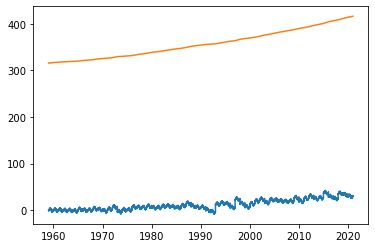

In [339]:
plt.plot(interpol_data_x, interpol_data_y)
plt.plot(x_yearly, y_yearly)